In [1]:
# %%
import os, sys, importlib, time, json
import numpy as np
import torch

print("Python:", sys.version)
print("Torch :", torch.__version__)
print("CUDA  :", torch.version.cuda)
print("GPU   :", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")

# 프로젝트 루트가 현재가 아니라면 아래처럼 경로 추가
# sys.path.append("/path/to/your/project")

# 0) 패키지 세팅
from pathlib import Path
import sys, importlib

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

# 2) 올바른 임포트 (패키지 경로 사용)
import utils as utils
import model as model
import data_loader as data_loader

importlib.reload(utils)
importlib.reload(model)
importlib.reload(data_loader)

from src.model import convnextv2_atto, convnextv2_nano, convnextv2_tiny
from src.data_loader import get_dataloaders, LensFITSBinaryDataset

print("✅ imports via 'src.*' ready")



Python: 3.12.0 | packaged by Anaconda, Inc. | (main, Oct  2 2023, 17:29:18) [GCC 11.2.0]
Torch : 2.6.0+cu124
CUDA  : 12.4
GPU   : Quadro RTX 5000


/home/users/mmingyeong/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ imports via 'src.*' ready


In [2]:
import predict as predict  # predict.py 모듈 임포트
import evaluate as evaluate  # evaluate.py 임포트

In [3]:
# %%
import types, sys, os, json
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 프로젝트 경로
# -----------------------
PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

import predict
import evaluate

# -----------------------
# 데이터 경로
# -----------------------
SLSIM_LENSES_DIR      = "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses"
SLSIM_NONLENSES_DIR   = "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses"
HSC_DEG_LENSES_DIR    = "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses"
HSC_DEG_NONLENSES_DIR = "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses"

# -----------------------
# 네 가지 실험 모드 폴더
# -----------------------
BASE_SAVE_DIR = PROJECT_ROOT / "_pilot_ckpt_20250903_161606"
EXPERIMENTS = {
    "raw_pad0_norm0": BASE_SAVE_DIR / "raw_pad0_norm0",
    "pad1_norm0":     BASE_SAVE_DIR / "pad1_norm0",
    "pad0_norm1":     BASE_SAVE_DIR / "pad0_norm1",
    "pad1_norm1":     BASE_SAVE_DIR / "pad1_norm1",
}

RESULTS = []

# -----------------------
# predict + evaluate 반복
# -----------------------
for tag, ckpt_dir in EXPERIMENTS.items():
    print(f"=== Running {tag} ===")
    out_pred_dir = ckpt_dir / "pred_outputs"
    out_eval_dir = ckpt_dir / "eval_outputs"
    out_pred_dir.mkdir(exist_ok=True)
    out_eval_dir.mkdir(exist_ok=True)

    # ---------- predict ----------
    args_pred = types.SimpleNamespace(
        slsim_lenses      = SLSIM_LENSES_DIR,
        slsim_nonlenses   = SLSIM_NONLENSES_DIR,
        hsc_lenses        = HSC_DEG_LENSES_DIR,
        hsc_nonlenses     = HSC_DEG_NONLENSES_DIR,
        which             = "test",
        batch_size        = 64,
        num_workers       = 4,
        train_frac        = 0.7,
        val_frac          = 0.15,
        test_frac         = 0.15,
        seed              = 42,
        take_test_fraction = 0.01,   # 속도용 샘플링 (실험시 None으로)
        model_path        = str(ckpt_dir / "best.pt"),
        model_size        = "atto",
        drop_path         = 0.0,
        device            = "cuda" if torch.cuda.is_available() else "cpu",
        output_dir        = str(out_pred_dir),
    )
    predict.main(args_pred)

    # ---------- evaluate ----------
    args_eval = types.SimpleNamespace(
        tag=tag,
        from_csv=False,
        from_npy=True,
        csv=None,
        labels=str(out_pred_dir / "labels_test.npy"),
        probs=str(out_pred_dir / "probs_test.npy"),
        preds=str(out_pred_dir / "preds_test.npy"),
        threshold=0.5,
        optimize_threshold=True,   # threshold 튜닝 활성화
        per_domain=False,
        plot=True,
        out_dir=str(out_eval_dir),
        seed=42,
    )
    evaluate.main(args_eval)

    # 결과 불러오기 (evaluate.py가 results.json 저장한다고 가정)
    res_json = out_eval_dir / f"results_{tag}.json"
    if res_json.exists():
        with open(res_json) as f:
            res = json.load(f)
        RESULTS.append({"mode": tag, **res})




2025-09-05 13:38:12,947 [INFO] [predict] 📦 Building dataloaders...


=== Running raw_pad0_norm0 ===


2025-09-05 13:38:13,874 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 13:38:14,877 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 13:38:15,881 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 13:38:16,822 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 13:38:16,824 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 13:38:17,725 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 13:38:17,754 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 13:

=== Running pad1_norm0 ===


2025-09-05 13:38:25,703 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 13:38:26,371 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 13:38:27,059 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 13:38:27,722 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 13:38:27,723 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 13:38:28,618 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 13:38:28,646 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 13:

=== Running pad0_norm1 ===


2025-09-05 13:38:31,775 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 13:38:32,459 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 13:38:33,165 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 13:38:33,847 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 13:38:33,849 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 13:38:34,762 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 13:38:34,790 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 13:

=== Running pad1_norm1 ===


2025-09-05 13:38:38,639 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 13:38:39,310 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 13:38:39,981 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 13:38:40,655 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 13:38:40,658 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 13:38:41,567 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 13:38:41,595 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 13:

,mode,test_loss,test_acc,test_auc,best_val_loss
0,raw_pad0_norm0,0.564569,0.718667,0.789649,0.543424
1,pad1_norm0,0.694741,0.492667,0.575672,0.692562
2,pad0_norm1,0.554658,0.755333,0.814313,0.529492
3,pad1_norm1,0.533935,0.736667,0.810982,0.510354


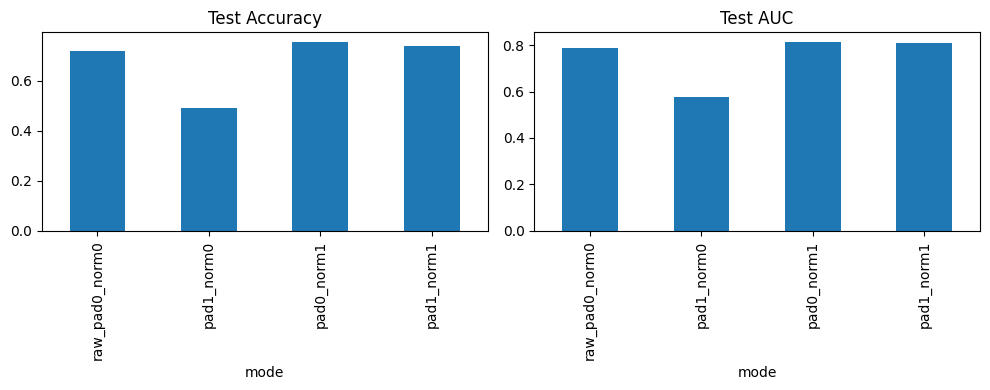

In [4]:
# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
BASE_SAVE_DIR = PROJECT_ROOT / "_pilot_ckpt_20250903_161606"

EXPERIMENTS = {
    "raw_pad0_norm0": BASE_SAVE_DIR / "raw_pad0_norm0" / "results.json",
    "pad1_norm0":     BASE_SAVE_DIR / "pad1_norm0" / "results.json",
    "pad0_norm1":     BASE_SAVE_DIR / "pad0_norm1" / "results.json",
    "pad1_norm1":     BASE_SAVE_DIR / "pad1_norm1" / "results.json",
}

results = []
for mode, path in EXPERIMENTS.items():
    with open(path) as f:
        data = json.load(f)
    row = {
        "mode": mode,
        "test_loss": data.get("test_loss", None),
        "test_acc":  data.get("test_acc", None),
        "test_auc":  data.get("test_auc", None),
        "best_val_loss": data.get("best_val_loss", None),
    }
    results.append(row)

df = pd.DataFrame(results)
display(df)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.plot(x="mode", y="test_acc", kind="bar", ax=axes[0], legend=False, title="Test Accuracy")
df.plot(x="mode", y="test_auc", kind="bar", ax=axes[1], legend=False, title="Test AUC")
plt.tight_layout()
plt.show()


/opt/anaconda3/2023.03/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/2023.03/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/2023.03/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt

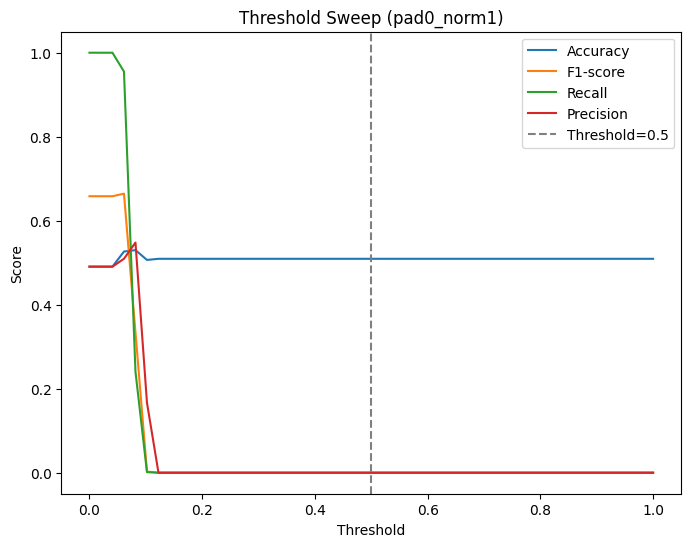

Best threshold by Youden's J = 0.000


In [5]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def threshold_sweep(labels, probs, num_points=50):
    thresholds = np.linspace(0, 1, num_points)
    accs, f1s, recalls, precisions = [], [], [], []

    for t in thresholds:
        preds = (probs >= t).astype(int)
        accs.append(accuracy_score(labels, preds))
        f1s.append(f1_score(labels, preds))
        recalls.append(recall_score(labels, preds))
        precisions.append(precision_score(labels, preds))

    return thresholds, accs, f1s, recalls, precisions


# 예시: pad0_norm1 결과에서 sweep 실행
import numpy as np
labels = np.load(BASE_SAVE_DIR / "pad0_norm1" / "pred_outputs" / "labels_test.npy")
probs  = np.load(BASE_SAVE_DIR / "pad0_norm1" / "pred_outputs" / "probs_test.npy")

ths, accs, f1s, recs, precs = threshold_sweep(labels, probs)

# Plot
plt.figure(figsize=(8,6))
plt.plot(ths, accs, label="Accuracy")
plt.plot(ths, f1s, label="F1-score")
plt.plot(ths, recs, label="Recall")
plt.plot(ths, precs, label="Precision")
plt.axvline(0.5, color="gray", linestyle="--", label="Threshold=0.5")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sweep (pad0_norm1)")
plt.legend()
plt.show()

# 최적 threshold (Youden's J)
youden = np.array(recs) + np.array(precs) - 1
best_idx = np.argmax(youden)
best_t = ths[best_idx]
print(f"Best threshold by Youden's J = {best_t:.3f}")


/opt/anaconda3/2023.03/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/2023.03/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/2023.03/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt

Best threshold (Youden's J): 0.050
Accuracy=0.493, F1=0.659, Recall=1.000, Precision=0.492


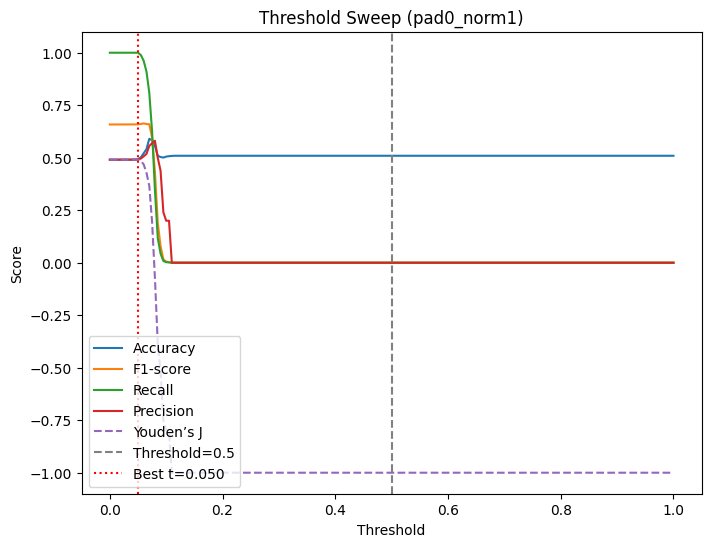

In [6]:
# %%
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

# pad0_norm1 예측 결과 불러오기
BASE_SAVE_DIR = Path("/caefs/user/mmingyeong/2508_slchallence/_pilot_ckpt_20250903_161606")
pred_dir = BASE_SAVE_DIR / "pad0_norm1" / "pred_outputs"

labels = np.load(pred_dir / "labels_test.npy")
probs  = np.load(pred_dir / "probs_test.npy")

# Threshold sweep
thresholds = np.linspace(0, 1, 201)
accs, f1s, recs, precs, youdens = [], [], [], [], []

for t in thresholds:
    preds = (probs >= t).astype(int)
    accs.append(accuracy_score(labels, preds))
    f1s.append(f1_score(labels, preds))
    recs.append(recall_score(labels, preds))
    precs.append(precision_score(labels, preds))
    youdens.append(recs[-1] + precs[-1] - 1)

# 최적 threshold (Youden’s J 기준)
best_idx = np.argmax(youdens)
best_t = thresholds[best_idx]
print(f"Best threshold (Youden's J): {best_t:.3f}")
print(f"Accuracy={accs[best_idx]:.3f}, F1={f1s[best_idx]:.3f}, Recall={recs[best_idx]:.3f}, Precision={precs[best_idx]:.3f}")

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, accs, label="Accuracy")
plt.plot(thresholds, f1s, label="F1-score")
plt.plot(thresholds, recs, label="Recall")
plt.plot(thresholds, precs, label="Precision")
plt.plot(thresholds, youdens, label="Youden’s J", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--", label="Threshold=0.5")
plt.axvline(best_t, color="red", linestyle=":", label=f"Best t={best_t:.3f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Sweep (pad0_norm1)")
plt.legend()
plt.show()


2025-09-05 14:08:02,264 [INFO] [predict] 📦 Building dataloaders...


=== Running raw_pad0_norm0 ===


2025-09-05 14:08:02,942 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 14:08:03,621 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 14:08:04,283 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 14:08:04,943 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 14:08:04,945 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 14:08:05,876 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 14:08:05,904 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 14:

=== Running pad1_norm0 ===


2025-09-05 14:08:08,966 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 14:08:09,614 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 14:08:10,269 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 14:08:10,928 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 14:08:10,929 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 14:08:11,854 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 14:08:11,882 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 14:

=== Running pad0_norm1 ===


2025-09-05 14:08:15,171 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 14:08:15,826 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 14:08:16,479 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 14:08:17,135 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 14:08:17,137 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 14:08:18,109 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 14:08:18,137 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 14:

=== Running pad1_norm1 ===


2025-09-05 14:08:22,238 [INFO] [predict] Collected 249999 from 'slsim_lenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses), label=1, domain=slsim
2025-09-05 14:08:22,892 [INFO] [predict] Collected 250000 from 'slsim_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses), label=0, domain=slsim
2025-09-05 14:08:23,571 [INFO] [predict] Collected 250000 from 'hsc_lenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses), label=1, domain=hsc
2025-09-05 14:08:24,228 [INFO] [predict] Collected 249999 from 'hsc_nonlenses' (/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses), label=0, domain=hsc
2025-09-05 14:08:24,229 [INFO] [predict] TOTAL files collected: 999998
2025-09-05 14:08:25,155 [INFO] [predict] Test subsampling: kept 1500/150001 (1.00%)
2025-09-05 14:08:25,183 [INFO] [predict] Dataset: N=699998 | lens=349999 | nonlens=349999 | augment=False | padding=True(out=64) | normalization=True | clip_q=0.997
2025-09-05 14:

,mode,test_loss,test_acc,test_auc,best_val_loss
0,raw_pad0_norm0,0.564569,0.718667,0.789649,0.543424
1,pad1_norm0,0.694741,0.492667,0.575672,0.692562
2,pad0_norm1,0.554658,0.755333,0.814313,0.529492
3,pad1_norm1,0.533935,0.736667,0.810982,0.510354


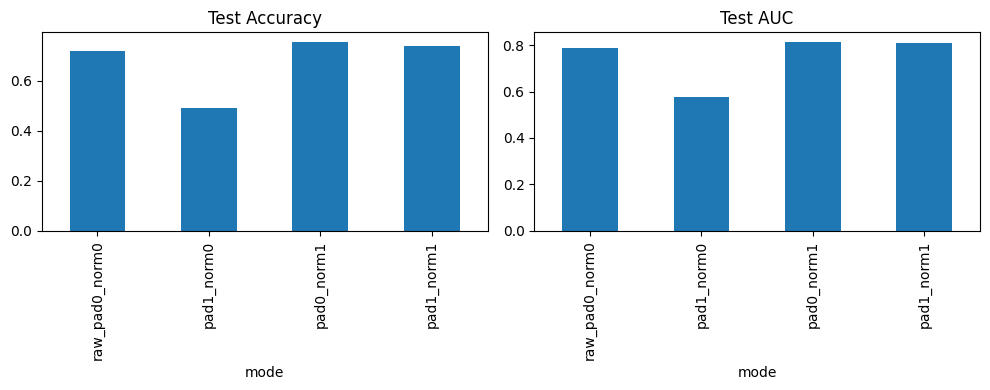

2025-09-05 14:08:28,188 [INFO] Loaded NPY: N=1500 (labels/probs) | preds=(1500,)
2025-09-05 14:08:28,216 [INFO] Saved metrics JSON → /caefs/user/mmingyeong/2508_slchallence/_pilot_ckpt_20250903_161606/pad0_norm1/eval_th0.5/metrics_pad0_norm1_th0.5.json
2025-09-05 14:08:28,219 [INFO] Saved metrics CSV → /caefs/user/mmingyeong/2508_slchallence/_pilot_ckpt_20250903_161606/pad0_norm1/eval_th0.5/metrics_pad0_norm1_th0.5.csv
2025-09-05 14:08:28,219 [INFO] Done.
2025-09-05 14:08:28,224 [INFO] Loaded NPY: N=1500 (labels/probs) | preds=(1500,)
2025-09-05 14:08:28,241 [INFO] Saved metrics JSON → /caefs/user/mmingyeong/2508_slchallence/_pilot_ckpt_20250903_161606/pad0_norm1/eval_th0.05/metrics_pad0_norm1_th0.05.json
2025-09-05 14:08:28,244 [INFO] Saved metrics CSV → /caefs/user/mmingyeong/2508_slchallence/_pilot_ckpt_20250903_161606/pad0_norm1/eval_th0.05/metrics_pad0_norm1_th0.05.csv
2025-09-05 14:08:28,244 [INFO] Done.
2025-09-05 14:08:28,248 [INFO] Loaded NPY: N=1500 (labels/probs) | preds=(15

In [11]:
# %%
import types, sys, os, json
from pathlib import Path
import torch
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 프로젝트 경로
# -----------------------
PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

import predict
import evaluate

# -----------------------
# 데이터 경로
# -----------------------
SLSIM_LENSES_DIR      = "/caefs/data/IllustrisTNG/slchallenge/slsim_lenses/slsim_lenses"
SLSIM_NONLENSES_DIR   = "/caefs/data/IllustrisTNG/slchallenge/slsim_nonlenses/slsim_nonlenses"
HSC_DEG_LENSES_DIR    = "/caefs/data/IllustrisTNG/slchallenge/hsc_lenses/hsc_lenses"
HSC_DEG_NONLENSES_DIR = "/caefs/data/IllustrisTNG/slchallenge/hsc_nonlenses/hsc_nonlenses"

# -----------------------
# 네 가지 실험 모드 폴더
# -----------------------
BASE_SAVE_DIR = PROJECT_ROOT / "_pilot_ckpt_20250903_161606"
EXPERIMENTS = {
    "raw_pad0_norm0": BASE_SAVE_DIR / "raw_pad0_norm0",
    "pad1_norm0":     BASE_SAVE_DIR / "pad1_norm0",
    "pad0_norm1":     BASE_SAVE_DIR / "pad0_norm1",
    "pad1_norm1":     BASE_SAVE_DIR / "pad1_norm1",
}

RESULTS = []

# -----------------------
# predict + evaluate 반복
# -----------------------
for tag, ckpt_dir in EXPERIMENTS.items():
    print(f"=== Running {tag} ===")
    out_pred_dir = ckpt_dir / "pred_outputs"
    out_eval_dir = ckpt_dir / "eval_outputs"
    out_pred_dir.mkdir(exist_ok=True)
    out_eval_dir.mkdir(exist_ok=True)

    # ---------- predict ----------
    args_pred = types.SimpleNamespace(
        slsim_lenses      = SLSIM_LENSES_DIR,
        slsim_nonlenses   = SLSIM_NONLENSES_DIR,
        hsc_lenses        = HSC_DEG_LENSES_DIR,
        hsc_nonlenses     = HSC_DEG_NONLENSES_DIR,
        which             = "test",
        batch_size        = 64,
        num_workers       = 4,
        train_frac        = 0.7,
        val_frac          = 0.15,
        test_frac         = 0.15,
        seed              = 42,
        take_test_fraction = 0.01,   # 속도용 샘플링 (실험시 None으로)
        model_path        = str(ckpt_dir / "best.pt"),
        model_size        = "atto",
        drop_path         = 0.0,
        device            = "cuda" if torch.cuda.is_available() else "cpu",
        output_dir        = str(out_pred_dir),
    )
    predict.main(args_pred)

    # ---------- evaluate ----------
    args_eval = types.SimpleNamespace(
        tag=tag,
        from_csv=False,
        from_npy=True,
        csv=None,
        labels=str(out_pred_dir / "labels_test.npy"),
        probs=str(out_pred_dir / "probs_test.npy"),
        preds=str(out_pred_dir / "preds_test.npy"),
        threshold=0.05,
        optimize_threshold=True,   # threshold 튜닝 활성화
        per_domain=False,
        plot=True,
        out_dir=str(out_eval_dir),
        seed=42,
    )
    evaluate.main(args_eval)

    # 결과 불러오기 (evaluate.py가 results.json 저장한다고 가정)
    res_json = out_eval_dir / f"results_{tag}.json"
    if res_json.exists():
        with open(res_json) as f:
            res = json.load(f)
        RESULTS.append({"mode": tag, **res})

# %%
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
BASE_SAVE_DIR = PROJECT_ROOT / "_pilot_ckpt_20250903_161606"

EXPERIMENTS = {
    "raw_pad0_norm0": BASE_SAVE_DIR / "raw_pad0_norm0" / "results.json",
    "pad1_norm0":     BASE_SAVE_DIR / "pad1_norm0" / "results.json",
    "pad0_norm1":     BASE_SAVE_DIR / "pad0_norm1" / "results.json",
    "pad1_norm1":     BASE_SAVE_DIR / "pad1_norm1" / "results.json",
}

results = []
for mode, path in EXPERIMENTS.items():
    with open(path) as f:
        data = json.load(f)
    row = {
        "mode": mode,
        "test_loss": data.get("test_loss", None),
        "test_acc":  data.get("test_acc", None),
        "test_auc":  data.get("test_auc", None),
        "best_val_loss": data.get("best_val_loss", None),
    }
    results.append(row)

df = pd.DataFrame(results)
display(df)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df.plot(x="mode", y="test_acc", kind="bar", ax=axes[0], legend=False, title="Test Accuracy")
df.plot(x="mode", y="test_auc", kind="bar", ax=axes[1], legend=False, title="Test AUC")
plt.tight_layout()
plt.show()



# %%
import types, sys, json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------
# 프로젝트 경로
# -----------------------
PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
SRC_DIR = PROJECT_ROOT / "src"
sys.path.insert(0, str(SRC_DIR))

import evaluate

# -----------------------
# pad0_norm1 experiment
# -----------------------
EXP_DIR = PROJECT_ROOT / "_pilot_ckpt_20250903_161606" / "pad0_norm1"
PRED_DIR = EXP_DIR / "pred_outputs"

LABELS_PATH = PRED_DIR / "labels_test.npy"
PROBS_PATH  = PRED_DIR / "probs_test.npy"
PREDS_PATH  = PRED_DIR / "preds_test.npy"

results = []

# -----------------------
# 1) 고정 threshold 0.5, 0.05
# -----------------------
for th in [0.5, 0.05]:
    args_eval = types.SimpleNamespace(
        tag=f"pad0_norm1_th{th}",
        from_csv=False,
        from_npy=True,
        labels=str(LABELS_PATH),
        probs=str(PROBS_PATH),
        preds=str(PREDS_PATH),
        threshold=th,
        optimize_threshold=False,   # 고정
        per_domain=False,
        plot=False,
        out_dir=str(EXP_DIR / f"eval_th{th}"),
        seed=42,
    )
    (EXP_DIR / f"eval_th{th}").mkdir(exist_ok=True)
    evaluate.main(args_eval)

    res_json = EXP_DIR / f"eval_th{th}" / f"metrics_pad0_norm1_th{th}.json"
    if res_json.exists():
        with open(res_json) as f:
            res = json.load(f)
        results.append({"mode": "pad0_norm1", "threshold": th, "type": f"fixed@{th}", **res})


# -----------------------
# 2) Optimal threshold (Youden’s J)
# -----------------------
args_eval = types.SimpleNamespace(
    tag="pad0_norm1_optimal",
    from_csv=False,
    from_npy=True,
    labels=str(LABELS_PATH),
    probs=str(PROBS_PATH),
    preds=str(PREDS_PATH),
    threshold=0.5,               # dummy, optimize_threshold=True로 무시됨
    optimize_threshold=True,     # 최적 threshold 찾기
    per_domain=False,
    plot=False,
    out_dir=str(EXP_DIR / "eval_optimal"),
    seed=42,
)
(EXP_DIR / "eval_optimal").mkdir(exist_ok=True)
evaluate.main(args_eval)

res_json = EXP_DIR / "eval_optimal" / "metrics_pad0_norm1_optimal.json"
if res_json.exists():
    with open(res_json) as f:
        res = json.load(f)
    results.append({"mode": "pad0_norm1", "threshold": res.get("best_threshold", None),
                    "type": "optimal", **res})



,mode,type,threshold,accuracy,precision,recall,f1,roc_auc
0,pad0_norm1,fixed@0.5,0.50000,0.509333,0.000000,0.000000,0.000000,0.599819
1,pad0_norm1,fixed@0.05,0.05000,0.509333,0.000000,0.000000,0.000000,0.599819
2,pad0_norm1,optimal,0.07019,0.592000,0.558052,0.809783,0.660754,0.599819


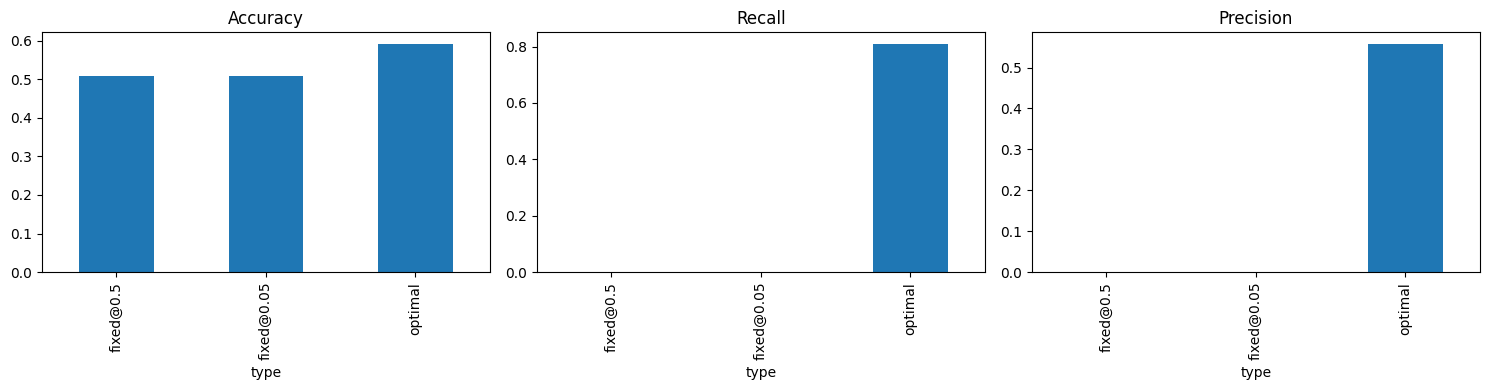

In [12]:
# %%
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_ROOT = Path("/caefs/user/mmingyeong/2508_slchallence")
EXP_DIR = PROJECT_ROOT / "_pilot_ckpt_20250903_161606" / "pad0_norm1"

# 세 가지 결과 파일 경로
files = {
    "fixed@0.5": EXP_DIR / "eval_th0.5" / "metrics_pad0_norm1_th0.5.csv",
    "fixed@0.05": EXP_DIR / "eval_th0.05" / "metrics_pad0_norm1_th0.05.csv",
    "optimal": EXP_DIR / "eval_optimal" / "metrics_pad0_norm1_optimal.csv",
}

rows = []
for name, path in files.items():
    df = pd.read_csv(path)
    # metric 열을 key로, value 열을 dict로 변환
    metrics = dict(zip(df["metric"], df["value"]))
    row = {
        "mode": "pad0_norm1",
        "type": name,
        "threshold": metrics.get("threshold", None),
        "accuracy": metrics.get("accuracy", None),
        "precision": metrics.get("precision", None),
        "recall": metrics.get("recall", None),
        "f1": metrics.get("f1", None),
        "roc_auc": metrics.get("roc_auc", None),
    }
    rows.append(row)

results = pd.DataFrame(rows)
display(results)

# -----------------------
# 시각화
# -----------------------
fig, axes = plt.subplots(1, 3, figsize=(15,4))

results.plot(x="type", y="accuracy", kind="bar", ax=axes[0], legend=False, title="Accuracy")
results.plot(x="type", y="recall", kind="bar", ax=axes[1], legend=False, title="Recall")
results.plot(x="type", y="precision", kind="bar", ax=axes[2], legend=False, title="Precision")

plt.tight_layout()
plt.show()
